# Fidelity Isn't Accuracy: When Linearly Decodable Functions Fail to Match the Ground Truth

The following code is from the paper *Fidelity Isn't Accuracy*. Please feel free to use and modify it however you'd like, but be sure to cite the paper!

## Abstract

Neural networks excel as function approximators, but their complexity often obscures the nature of the functions they learn. In this work, we propose the linearity score $\lambda(f)$, a simple and interpretable diagnostic that quantifies how well a regression network's output can be mimicked by a linear model. Defined as the $R^2$ between the network's predictions and those of a trained linear surrogate, $\lambda(f)$ offers insight into the linear decodability of the learned function. We evaluate this framework on both synthetic ($y = x \cdot \sin(x) + \epsilon$) and real-world datasets (Medical Insurance, Concrete, California Housing), using dataset-specific networks and surrogates. Our findings show that while high $\lambda(f)$ scores indicate strong linear alignment, they do not necessarily imply predictive accuracy with respect to the ground truth. This underscores both the promise and the limitations of using linear surrogates to understand nonlinear model behavior—particularly in high-stakes regression tasks.

## Citation

*TODO: Add `bibtex`*

## Table of Contents

1. Definition of Linearity Score $\lambda(f)$
2. Experimental Framework
3. **Experiment 1**: Synthetic Dataset ($x \cdot \sin x + \epsilon$)
4. **Experiment 2**: Medical Insurance Cost
5. **Experiment 3**: Concrete Compressive Strength
6. **Experiment 4**: California Housing
7. Conclusion

## How to Use

To reproduce the published study, simply run all cells from top to bottom. To apply $\lambda(f)$ to your own data, add a cell and use the boilerplate to run your experiment.

## Dependencies

- Python 3.8+
- NumPy
- scikit-learn
- TensorFlow
- MatplotLib
- Pandas
- kagglehub
- seaborn

## License
This code is provided as-is, and all modification and redistribution of it is permitted as long as the original work is attributed correctly and clearly to the author.

In [24]:
!pip install ucimlrepo

In [31]:
## Imports ##

# General utilities
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn components
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Datasets
import kagglehub
from kagglehub import KaggleDatasetAdapter
from ucimlrepo import fetch_ucirepo
from sklearn.datasets import fetch_california_housing


## Setup ##

np.random.seed(42)
tf.random.set_seed(42)

## 1. Linearity Score $\lambda(f)$

This section provides a brief overview of $\lambda(f)$. For full details and motivation, please refer to the paper—especially Section 3.

Let $ \mathcal{L} $ denote the subspace of affine (linear) functions. Then define:

$$ \lambda(f) := R^2(f, g^*), \text{ where }  g^* = \arg\min_{g \in \mathcal{L}} \mathbb{E}_{x \sim \mathcal{D}} \left[(f(x) - g(x))^2\right] $$

Plainly, $\lambda(f)$ is the coefficient of determination ($R^2$ score) between a neural network $f$ and the best linear approximation $g^*$. Importantly, $g^*$ is chosen to approximate the outputs of the network $f$, not the original data. Thus, $\lambda(f)$ measures how well the learned function itself can be mimicked by a linear model, independent of ground truth.

In [9]:
def lambda_score(f_preds: np.ndarray, g_preds: np.ndarray) -> float:
    """
    Computes λ(f, g) = R²(f(x), g(x)), i.e., how well g mimics f.

    Parameters:
    - f_preds: predictions from the neural network (f(x))
    - g_preds: predictions from the mimic linear model (g(x))

    Returns:
    - λ score (float): R^2 score between f_preds and g_preds
    """
    return r2_score(f_preds, g_preds)

## 2. Experimental Framework

The following code defines a standardized procedure for evaluating the linearity score \( \lambda(f) \) across multiple datasets and model runs. Each experiment consists of:

- Training a baseline linear regression model.
- Training a neural network on the same data.
- Fitting a linear surrogate (the "mimic model") to approximate the neural network’s output.
- Computing \( \lambda(f) \), the \( R^2 \) between the network's output and the surrogate.

This procedure is repeated multiple times to gather statistics (mean and standard deviation) on model performance and linear decodability.

You can easily adapt this framework to your own datasets or architectures by modifying the data inputs and network-building function.

In [10]:
def run_experiment(X_train, y_train, X_test, y_test, build_network, n=5):
    """
    Runs an experiment on given data using a compiled NN model returned by build_network().

    Parameters:
    - X_train, y_train: training data and labels
    - X_test, y_test: testing data and labels
    - build_network: a function that returns a compiled but untrained model
    - n: number of experiment repetitions
    """
    baseline_scores = []
    nn_scores = []
    mimic_scores = []
    lambda_scores = []

    baseline_test_preds = []
    nn_test_preds = []
    mimic_test_preds = []

    for _ in range(n):
        ### Baseline Linear Regression ###
        baseline_lr = LinearRegression()
        baseline_lr.fit(X_train, y_train)
        y_pred_lr = baseline_lr.predict(X_test)

        baseline_scores.append(r2_score(y_test, y_pred_lr))
        baseline_test_preds.append(y_pred_lr)

        ### Neural Network ###
        model = build_network()  # Create fresh model
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
        f_test = model.predict(X_test).flatten()

        nn_scores.append(r2_score(y_test, f_test))
        nn_test_preds.append(f_test)

        ### Mimic Model ###
        f_train = model.predict(X_train).flatten()
        mimic_lr = LinearRegression()
        mimic_lr.fit(X_train, f_train)
        g_test = mimic_lr.predict(X_test)

        mimic_scores.append(r2_score(y_test, g_test))
        lambda_scores.append(lambda_score(f_test, g_test))
        mimic_test_preds.append(g_test)

    # Compute statistics
    stats = {
        'baseline_mean': np.mean(baseline_scores),
        'nn_mean': np.mean(nn_scores),
        'mimic_mean': np.mean(mimic_scores),
        'lambda_mean': np.mean(lambda_scores),
        'baseline_sd': np.std(baseline_scores),
        'nn_sd': np.std(nn_scores),
        'mimic_sd': np.std(mimic_scores),
        'lambda_sd': np.std(lambda_scores),
        'baseline_scores': baseline_scores,
        'nn_scores': nn_scores,
        'mimic_scores': mimic_scores,
        'lambda_scores': lambda_scores,
        'baseline_test_preds': baseline_test_preds,
        'nn_test_preds': nn_test_preds,
        'mimic_test_preds': mimic_test_preds,
    }

    return stats

In [11]:
def plot_experiment_run(y_test, baseline_preds, nn_preds, mimic_preds, title_prefix=""):
    """
    Plots the results of one experiment run with three scatterplots:
    - True y vs. Baseline Linear Regression prediction
    - True y vs. Neural Network prediction
    - Neural Network output vs. Mimic Linear Model prediction

    Parameters:
    - y_test: true test labels
    - baseline_preds: predictions from baseline linear regression
    - nn_preds: predictions from neural network
    - mimic_preds: predictions from linear surrogate trained to match NN
    - title_prefix: optional prefix string to prepend to each subplot title
    """

    def add_subplot(ax, x, y, title, xlabel, ylabel):
        ax.scatter(x, y, alpha=0.3)
        min_val = min(np.min(x), np.min(y))
        max_val = max(np.max(x), np.max(y))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    add_subplot(axes[0], y_test, baseline_preds,
                f"{title_prefix}1. Baseline Linear Regression", "True y", "Predicted y")

    add_subplot(axes[1], y_test, nn_preds,
                f"{title_prefix}2. Neural Network", "True y", "NN Prediction")

    add_subplot(axes[2], nn_preds, mimic_preds,
                f"{title_prefix}3. Mimic Model vs NN Output", "NN Prediction f(x)", "Mimic Prediction g(x)")

    plt.tight_layout()
    plt.show()

## 3. **Experiment 1**: Synthetic Dataset ($x \sin x + \varepsilon$)

In this experiment, we evaluate our linearity score $\lambda(f)$ on a synthetic dataset where the ground truth function is known and globally nonlinear. Specifically, the target function is $y = x \cdot \sin(x) + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ represents Gaussian noise.

This dataset was selected to serve as a clear counterexample to linear decodability. Despite being smooth and predictable, the function exhibits no regions of local linearity that a simple model could exploit. We expect:

- the baseline linear model to perform poorly,  
- the neural network to capture the structure well, and  
- the linear surrogate to fail to mimic the network's predictions, resulting in a **low** $\lambda(f)$ score.

This setup helps illustrate a key property of $\lambda(f)$: it can quantify when a network's learned function is fundamentally nonlinear—even when the network itself performs extremely well.

Below, you can visualize the dataset, then run the experiment.

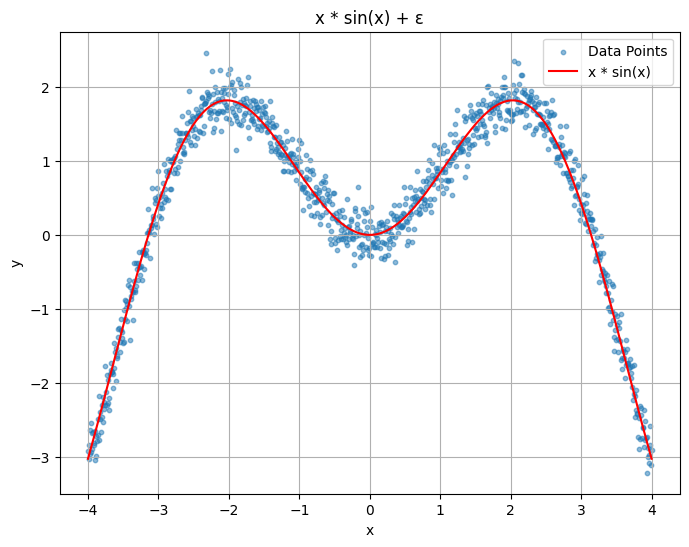

In [12]:
### Generate x * sin(x) dataset ###
np.random.seed(42)
X = np.linspace(-4, 4, 1000).reshape(-1, 1)
y = X.flatten() * np.sin(X.flatten()) + np.random.normal(0, 0.2, X.shape[0])

### Plot the Data ###
plt.figure(figsize=(8, 6))
plt.scatter(X, y, s=10, alpha=0.5, label='Data Points')
plt.plot(X, X.flatten() * np.sin(X.flatten()), color='red', label='x * sin(x)')
plt.title('x * sin(x) + ε')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Experiment 1 Results:

Baseline Regression R^2:        -0.0080
Mean:                           -0.0080
Standard Deviation:             0.0000

Neural Network R^2:             0.9755
Mean:                           0.9753
Standard Deviation:             0.0002

Mimic Regression R^2:           -0.0137
Mean:                           -0.0140
Standard Deviation:             0.0005

Linearity Score λ(f):           -0.0105
Mean:                           -0.0107
Standard Deviation:             0.0004


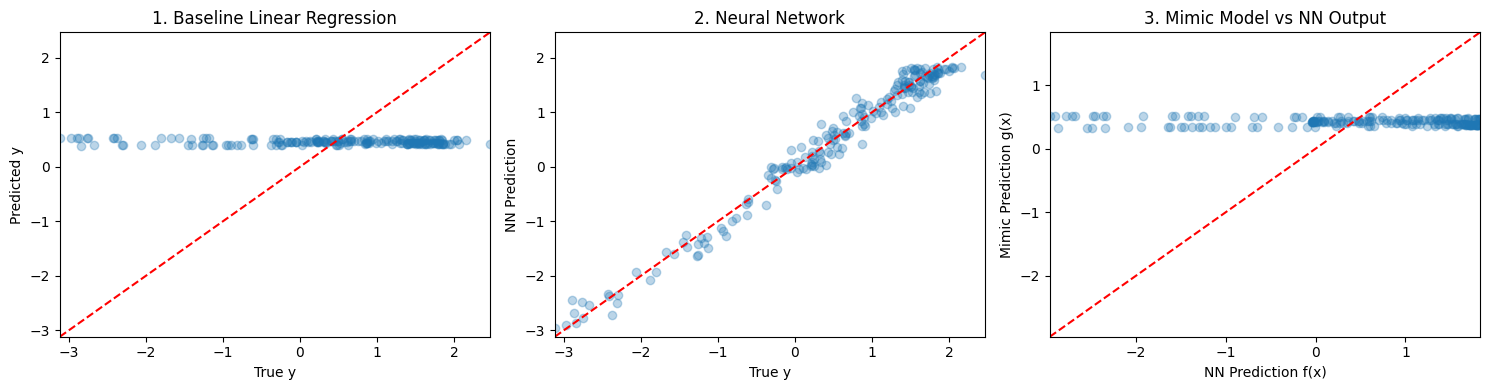

In [15]:
### Train/test split ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize features ###
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Build network builder ###
def build_network():
    input_dim = X_train_scaled.shape[1]
    nn_model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(64, activation="relu"),
        Dense(1, activation="linear")
    ])
    nn_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return nn_model

### Run Experiment ###
results = run_experiment(X_train_scaled, y_train, X_test_scaled, y_test, build_network, n=5)

### Print Results ###
print("Experiment 1 Results:\n")

print(f"Baseline Regression R^2:        {results['baseline_scores'][0]:.4f}")
print(f"Mean:                           {results['baseline_mean']:.4f}")
print(f"Standard Deviation:             {results['baseline_sd']:.4f}\n")

print(f"Neural Network R^2:             {results['nn_scores'][0]:.4f}")
print(f"Mean:                           {results['nn_mean']:.4f}")
print(f"Standard Deviation:             {results['nn_sd']:.4f}\n")

print(f"Mimic Regression R^2:           {results['mimic_scores'][0]:.4f}")
print(f"Mean:                           {results['mimic_mean']:.4f}")
print(f"Standard Deviation:             {results['mimic_sd']:.4f}\n")

print(f"Linearity Score λ(f):           {results['lambda_scores'][0]:.4f}")
print(f"Mean:                           {results['lambda_mean']:.4f}")
print(f"Standard Deviation:             {results['lambda_sd']:.4f}")

### Plot a single run ###
plot_experiment_run(y_test, results['baseline_test_preds'][0],
                    results['nn_test_preds'][0], results['mimic_test_preds'][0])

## 4. Experiment 2: Medical Insurance Costs

In this experiment, we apply our linearity score $\lambda(f)$ to a real-world dataset of medical insurance charges. The dataset includes demographic and lifestyle features such as age, sex, body mass index (BMI), number of children, smoking status, and residential region. The target variable is charges, representing the total medical cost billed to each individual.

While the dataset contains some nonlinear interactions—particularly involving smoking status and BMI—much of its structure is linearly explainable. As a result, we expect:
- the baseline linear model to perform reasonably well,
- the neural network to capture additional nonlinear signal, and
- the linear surrogate to partially mimic the network's predictions, yielding a moderate $\lambda(f)$ score.

This experiment illustrates a middle-ground case, where linearity and nonlinearity coexist. It helps demonstrate how $\lambda(f)$ can quantify the degree of linear structure in a learned function, even when that structure is not perfect.

<ipython-input-18-357545410>:3: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


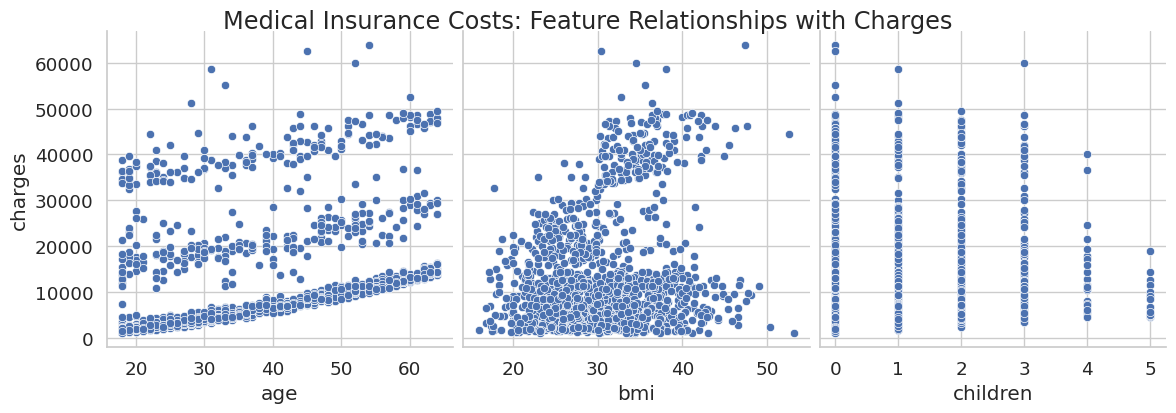

In [18]:
file_path = "insurance.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mirichoi0218/insurance",
  file_path)

sns.set(style="whitegrid", font_scale=1.2)
sns.pairplot(df, x_vars=['age', 'bmi', 'children'], y_vars='charges', height=4, aspect=1, kind='scatter')
plt.suptitle('Medical Insurance Costs: Feature Relationships with Charges', y=1.02)
plt.show()

In [19]:
X = df.drop('charges', axis=1)  # Features
y = df['charges']               # Target variable

### Identify categorical and numerical columns ###
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

### Preprocessing ###
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

### Train-test split ###
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Experiment 2 Results:

Baseline Regression R^2:        0.7836
Mean:                           0.7836
Standard Deviation:             0.0000

Neural Network R^2:             0.8587
Mean:                           0.8660
Standard Deviation:             0.0039

Mimic Regression R^2:           0.7839
Mean:                           0.7835
Standard Deviation:             0.0002

Linearity Score λ(f):           0.9331
Mean:                           0.9198
Standard Deviation:             0.0073


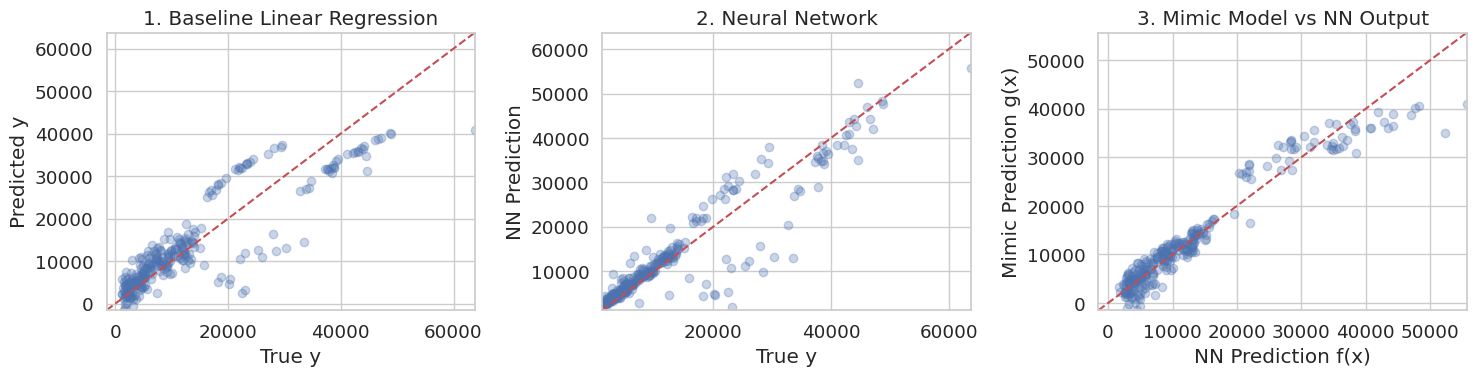

In [21]:

### Build network builder ###
def build_network():
    nn = Sequential([
        Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    nn.compile(optimizer=Adam(learning_rate=0.01), loss="mse")
    return nn

### Run Experiment ###
results = run_experiment(X_train, y_train, X_test, y_test, build_network, n=5)

### Print Results ###
print("Experiment 2 Results:\n")

print(f"Baseline Regression R^2:        {results['baseline_scores'][0]:.4f}")
print(f"Mean:                           {results['baseline_mean']:.4f}")
print(f"Standard Deviation:             {results['baseline_sd']:.4f}\n")

print(f"Neural Network R^2:             {results['nn_scores'][0]:.4f}")
print(f"Mean:                           {results['nn_mean']:.4f}")
print(f"Standard Deviation:             {results['nn_sd']:.4f}\n")

print(f"Mimic Regression R^2:           {results['mimic_scores'][0]:.4f}")
print(f"Mean:                           {results['mimic_mean']:.4f}")
print(f"Standard Deviation:             {results['mimic_sd']:.4f}\n")

print(f"Linearity Score λ(f):           {results['lambda_scores'][0]:.4f}")
print(f"Mean:                           {results['lambda_mean']:.4f}")
print(f"Standard Deviation:             {results['lambda_sd']:.4f}")

### Plot a single run ###
plot_experiment_run(y_test, results['baseline_test_preds'][0],
                    results['nn_test_preds'][0], results['mimic_test_preds'][0])

## 5. **Experiment 3**: Concrete Compressive Strength

In this experiment, we evaluate \( \lambda(f) \) on the Concrete Compressive Strength dataset, which aims to predict the strength of concrete based on the proportions of its ingredients (cement, water, ash, aggregates, etc.) and its age in days.

This dataset is known for its moderate complexity. While some relationships between features and compressive strength are approximately linear (e.g., increasing cement typically increases strength), others are nonlinear or involve interactions (e.g., age and water content). Consequently, we expect:

- the neural network to capture these nonlinear patterns and outperform a linear model,  
- the baseline linear model to perform reasonably but with room for improvement, and  
- the mimic model to track the neural network moderately well—yielding a **medium** \( \lambda(f) \) score.

This experiment highlights a middle-ground case: the surrogate captures some—but not all—of the network’s predictive structure, and \( \lambda(f) \) reflects that partial alignment.

In [26]:
# fetch dataset
concrete_compressive_strength = fetch_ucirepo(id=165)

# data (as pandas dataframes)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets

# metadata
print(concrete_compressive_strength.metadata)

# variable information
print(concrete_compressive_strength.variables)


{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 383, 'type': 'NATIVE', 'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'venue': 'C

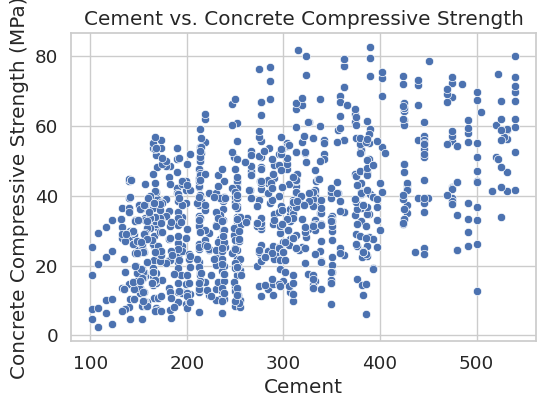

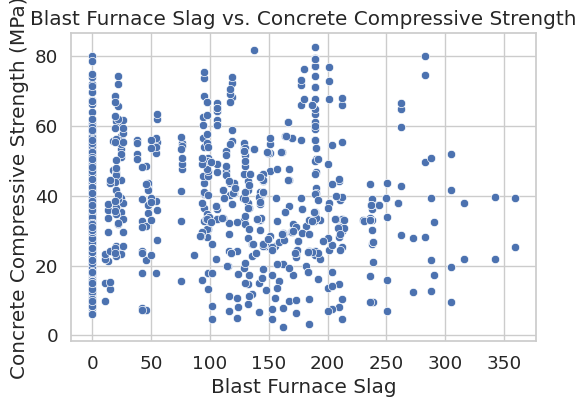

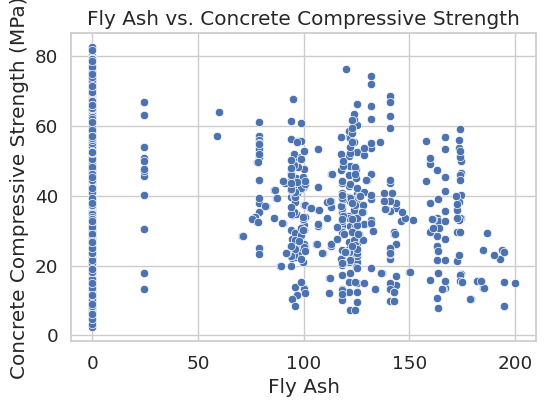

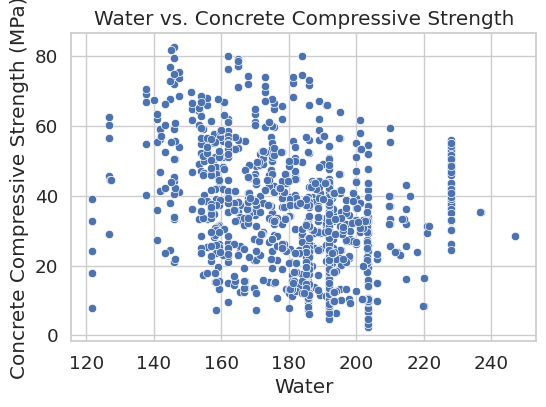

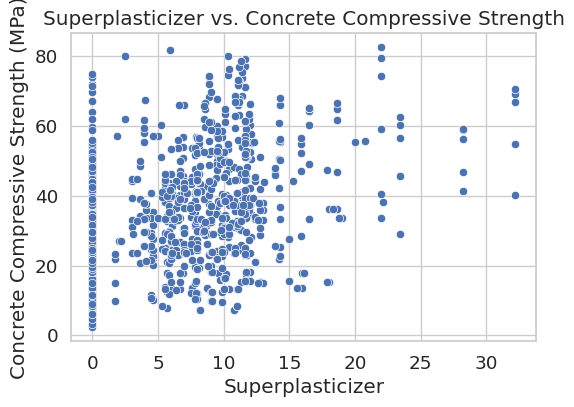

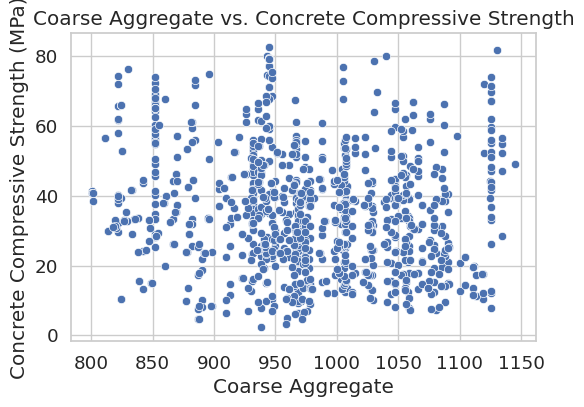

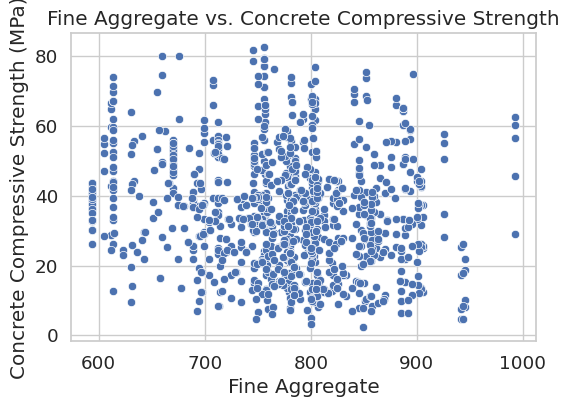

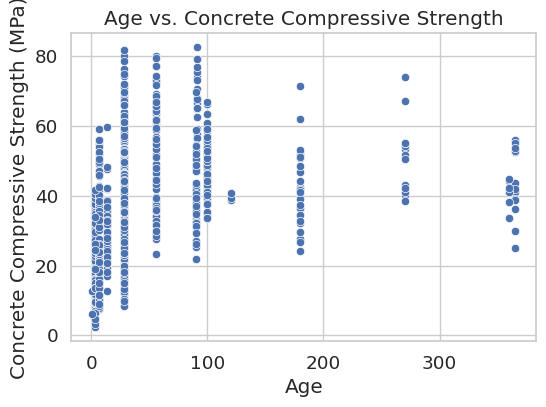

In [27]:
# Convert X to DataFrame for easier plotting with seaborn

X_df = pd.DataFrame(X, columns=concrete_compressive_strength.variables.name[concrete_compressive_strength.variables.role=='Feature'])

# Get the correct column name for the target variable
target_column_name = concrete_compressive_strength.variables.name[concrete_compressive_strength.variables.role=='Target'].iloc[0]

# Plotting relationships with target variable
for idx, feature in enumerate(X_df.columns):
    plt.figure(figsize=(6, 4))  # Adjust size as needed
    # Use the correct target column name here
    sns.scatterplot(x=X_df[feature], y=y[target_column_name])
    plt.title(f'{feature} vs. Concrete Compressive Strength')
    plt.xlabel(feature)
    plt.ylabel('Concrete Compressive Strength (MPa)')
    plt.savefig(f'concrete_{idx}.png')
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Experiment Results:

Baseline Regression R²:        0.5944
Mean:                          0.5944
Standard Deviation:            0.0000

Neural Network R²:             0.8457
Mean:                          0.8580
Standard Deviation:            0.0110

Mimic Regression R²:           0.5772
Mean:                          0.5788
Standard Deviation:            0.0029

Linearity Score λ(f):          0.6751
Mean:                          0.6616
Standard Deviation:            0.0081



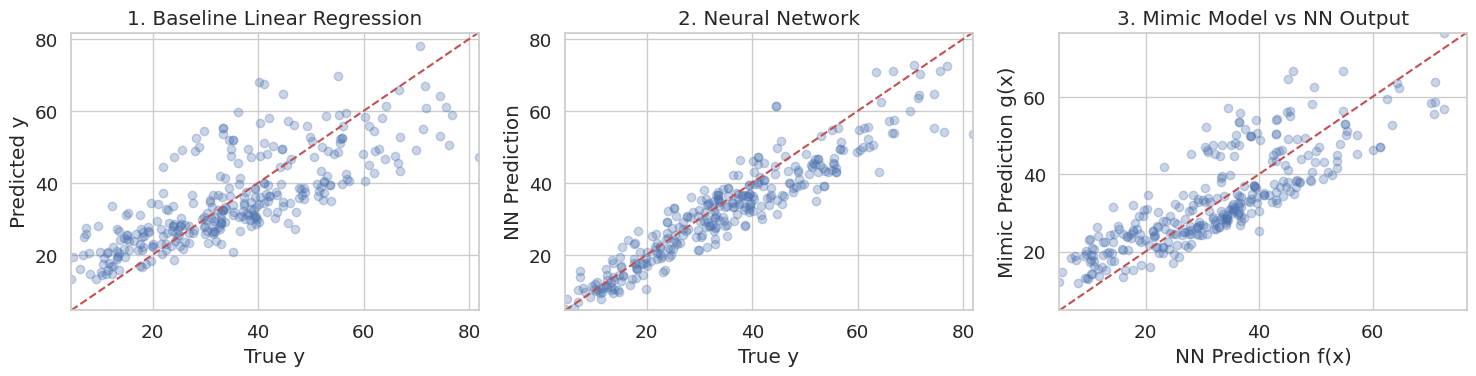

In [30]:
# === Preprocess ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# === Define Network Builder ===
def build_network():
    model = Sequential([
        Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dropout(0.1),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return model

# === Run Experiment ===
results = run_experiment(X_train, y_train, X_test, y_test, build_network, n=5)

# === Print Results ===
print("Experiment Results:\n")

print(f"Baseline Regression R²:        {results['baseline_scores'][0]:.4f}")
print(f"Mean:                          {results['baseline_mean']:.4f}")
print(f"Standard Deviation:            {results['baseline_sd']:.4f}\n")

print(f"Neural Network R²:             {results['nn_scores'][0]:.4f}")
print(f"Mean:                          {results['nn_mean']:.4f}")
print(f"Standard Deviation:            {results['nn_sd']:.4f}\n")

print(f"Mimic Regression R²:           {results['mimic_scores'][0]:.4f}")
print(f"Mean:                          {results['mimic_mean']:.4f}")
print(f"Standard Deviation:            {results['mimic_sd']:.4f}\n")

print(f"Linearity Score λ(f):          {results['lambda_scores'][0]:.4f}")
print(f"Mean:                          {results['lambda_mean']:.4f}")
print(f"Standard Deviation:            {results['lambda_sd']:.4f}\n")

# === Plot a Representative Run ===
plot_experiment_run(y_test, results['baseline_test_preds'][0],
                    results['nn_test_preds'][0],
                    results['mimic_test_preds'][0])

## 6. **Experiment 4**: California Housing Dataset

In this experiment, we evaluate $\lambda(f)$ on the well-known California Housing dataset, which predicts median house value in a district based on features such as population, income, and number of rooms.

Unlike our synthetic dataset, this real-world task contains complex patterns and mild nonlinearity—ideal for neural networks to exploit. However, these patterns may or may not be linearly decodable, depending on how the learned function represents them.

We expect:

- the baseline linear model to do reasonably well,  
- the neural network to outperform it in predictive accuracy, and  
- the mimic model to approximate the network to varying degrees depending on linearity.

This experiment demonstrates how $\lambda(f)$ helps quantify the **decodability** of a model's learned representation—even when that representation improves performance over traditional models.

**Note**: This experiment may take longer to run due to the larger size of the dataset.

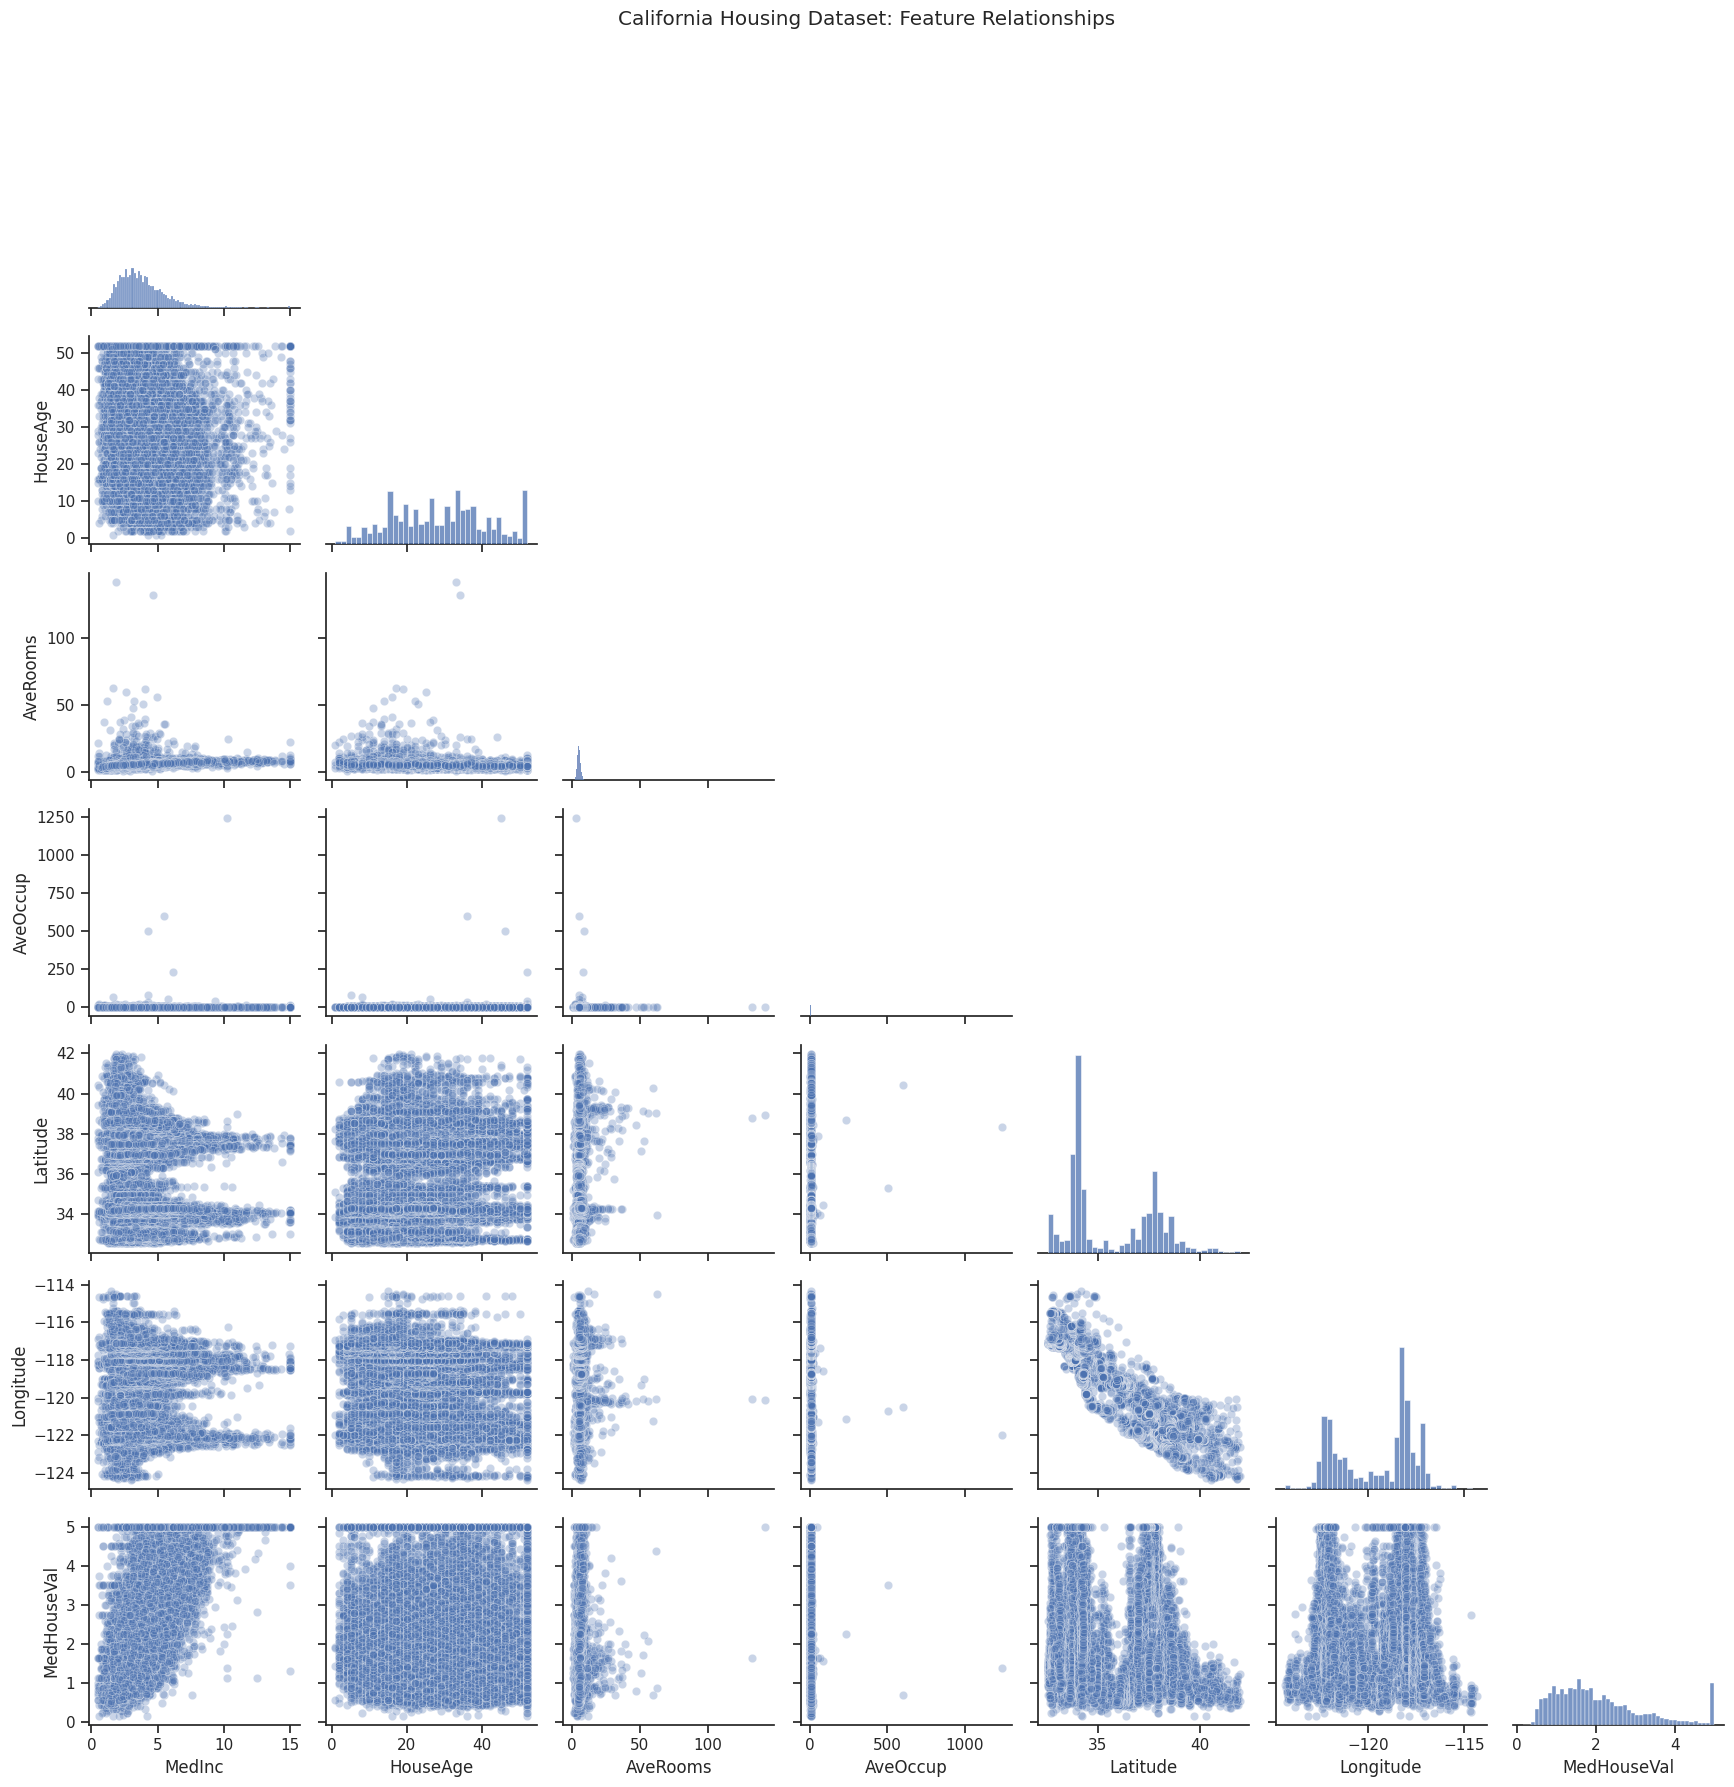

In [32]:
# Load dataset
data = fetch_california_housing(as_frame=True)
df = data.frame

# Select features to visualize
selected_features = [
    'MedInc', 'HouseAge', 'AveRooms', 'AveOccup',
    'Latitude', 'Longitude', 'MedHouseVal'
]

# Plot pairplot
sns.set(style="ticks", color_codes=True)
pairplot = sns.pairplot(df[selected_features], corner=True, plot_kws={'alpha': 0.3})
pairplot.fig.suptitle("California Housing Dataset: Feature Relationships", y=1.02)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Experiment 4 Results:

Baseline Regression R²:        0.5758
Mean:                           0.5758
Standard Deviation:             0.0000

Neural Network R²:             0.7867
Mean:                           0.7884
Standard Deviation:             0.0031

Mimic Regression R²:           0.5642
Mean:                           0.5637
Standard Deviation:             0.0027

Linearity Score λ(f):          0.6946
Mean:                           0.6928
Standard Deviation:             0.0090


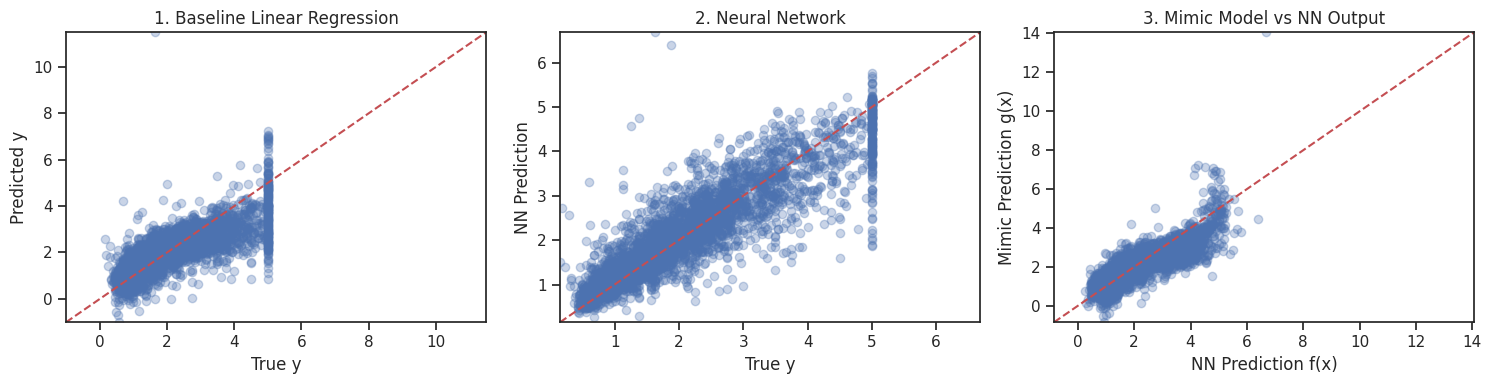

In [33]:
# Load the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define network builder
def build_network():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
        Dense(64, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Run experiment
results = run_experiment(X_train_scaled, y_train, X_test_scaled, y_test, build_network, n=5)

# Print results
print("Experiment 4 Results:\n")

print(f"Baseline Regression R²:        {results['baseline_scores'][0]:.4f}")
print(f"Mean:                           {results['baseline_mean']:.4f}")
print(f"Standard Deviation:             {results['baseline_sd']:.4f}\n")

print(f"Neural Network R²:             {results['nn_scores'][0]:.4f}")
print(f"Mean:                           {results['nn_mean']:.4f}")
print(f"Standard Deviation:             {results['nn_sd']:.4f}\n")

print(f"Mimic Regression R²:           {results['mimic_scores'][0]:.4f}")
print(f"Mean:                           {results['mimic_mean']:.4f}")
print(f"Standard Deviation:             {results['mimic_sd']:.4f}\n")

print(f"Linearity Score λ(f):          {results['lambda_scores'][0]:.4f}")
print(f"Mean:                           {results['lambda_mean']:.4f}")
print(f"Standard Deviation:             {results['lambda_sd']:.4f}")

# Plot a single run
plot_experiment_run(y_test, results['baseline_test_preds'][0],
                    results['nn_test_preds'][0], results['mimic_test_preds'][0])

## 7. Conclusion

In this notebook, we demonstrated how to use the linearity score $\lambda(f)$ to evaluate the linear decodability of neural network regressors across a variety of datasets. Our experiments showed that:

- A high $\lambda(f)$ score indicates that a neural network's outputs can be closely mimicked by a linear model.
- However, this does **not** guarantee that the model is accurate with respect to the ground truth.
- In fact, even perfect mimicry of a poorly performing network offers little practical value.

These findings support the central thesis of the paper: **fidelity is not accuracy**. $\lambda(f)$ is a useful diagnostic tool—but it must be interpreted carefully.


### For More Detail
Refer to the full paper [*Fidelity Isn’t Accuracy*] for theoretical discussion, further experiments, and recommendations on using linear surrogates in practice.


### Feedback?
If you find this notebook useful or have suggestions, feel free to reach out ([eshbaugj@lafayette.edu](mailto:eshbaugj@lafayette.edu); [jacksoneshbaugh.github.io](https://jacksoneshbaugh.github.io)) or cite the work!

_This notebook accompanies the paper_ **Fidelity Isn't Accuracy**, _by Jackson Eshbaugh._  
_Lafayette College, 2025._